## GROUP 48
### Topic E - Predicting Project Success
###April 13, 2020

# **EXPLORATORY DATA ANALYSIS**

# *Note: Please see PDF file enclosed for formal report*


**Team Members:**
- Michael Lee, *mil726@g.harvard.edu*
- Micah Nickerson, *min021@g.harvard.edu*
-Daniel Olal, *dolal@crystal.harvard.edu*


**Project TF**
- Brandon Walker


**Project Topic**

Successful project planning is a critical part of the success of any business or organization in order to minimize unanticipated delays or cost overruns.  With our data science models, we strive to predict project success or failure based on historical project planning records.

For this analysis, we define project success as a combination of two metrics: **budgetary success** and **schedule success**.  Budgetary success occurs when the project is completed **on budget**, and schedule success occurs when the project is completed **on schedule**. Note that on budget and on schedule indicates that the project is completed **within an interval of acceptable deviation**, with upper and lower bounds still to be determined.

**Description of Data Set**

Our dataset is a **collection of capital projects provided by the Mayor’s Office of Operations in New York City**.  The projects in the database include projects managed by NYC city agencies which have a budget of $25 million or more.   The information in the dataset includes the date of the project status update, the project ID (PID), the project name, the project description, and the category of the project.  Details about the borough, managing agency, client agency are also provided.  The progress of the project is defined based on variables including the current phase of the project, design start date, budget forecast, the latest budget changes, the total budget changes, forecast completion, latest schedule changes, and total schedule changes. The **dataset contains multiple rows per project** (per PID), providing time stamped sequential updates to each of the forecast completion, latest budget changes and latest schedule changes.

*- Load Dependencies*

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot
import matplotlib.pylab as plt 
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam, SGD


- *Load and Clean Data:*
  - This notebook was created and run in Google Colab Pro. 
  - Below are Colab Specific files:

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
####### GRAPHICS PROCESSING UNITS #######

#With Colab Pro you have priority access to our fastest GPUs.
#For example, you may get a T4 or P100 GPU at times when most users of standard Colab receive a slower K80 GPU.
#You can see what GPU you've been assigned at any time by executing the following cell.

print("####### GRAPHICS PROCESSING UNITS #######\n")
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)


####### VIRTUAL MEMORY #######

#With Colab Pro you have the option to access high-memory VMs when they are available.
#To set your notebook preference to use a high-memory runtime, select the Runtime → 'Change runtime type' menu, and then select High-RAM in the Runtime shape dropdown.
#You can see how much memory you have available at any time by running the following code.
print("####### GRAPHICS PROCESSING UNITS #######\n")

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

####### GRAPHICS PROCESSING UNITS #######

Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, 
and then re-execute this cell.
####### GRAPHICS PROCESSING UNITS #######

Your runtime has 13.7 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime → "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


- *Load and Clean the Dataset*

In [0]:
# read the file

filepath = "/content/drive/Shared drives/CSCI E-109B - Adv Data Sci - Final Project (E)/Data/"
nyc_cp_path = "Capital_Projects.csv"
nyc_cp = filepath+nyc_cp_path

nyc_cp_df = pd.read_csv(nyc_cp, encoding= 'unicode_escape')


nyc_cp_df.columns = ['Column_Description','Date_Reported_As_Of', 'PID', 'Project_Name', 'Description', 'Category',
       'Borough', 'Managing_Agency', 'Client_Agency', 'Current_Phase',
       'Design_Start', 'Budget_Forecast', 'Latest_Budget_Changes',
       'Total_Budget_Changes', 'Forecast_Completion',
       'Latest_Schedule_Changes', 'Total_Schedule_Changes']

nyc_cp_df.dropna(subset=['Design_Start'])

#this function has issues converting Design_Start
datetime_cols = ['Date_Reported_As_Of', 'Design_Start', 'Forecast_Completion']
for cols in datetime_cols:
    try:
      nyc_cp_df[cols] = pd.to_datetime(nyc_cp_df[cols])
    except:
      pass

numeric_cols = ['PID',	'Budget_Forecast',	'Latest_Budget_Changes',	'Total_Budget_Changes',	'Latest_Schedule_Changes',	'Total_Schedule_Changes']
for cols in numeric_cols:
    try:
      nyc_cp_df[cols] = pd.to_numeric(nyc_cp_df[cols],errors='coerce')
    except:
      pass

nyc_cp_df_labels = nyc_cp_df[0:2]
nyc_cp_df = nyc_cp_df.drop([0,1], axis =0)
#nyc_cp_df = nyc_cp_df.drop(['Column_Description'], axis =1)

#convert Design_Start to datetime
nyc_cp_df['Design_Start'] = pd.to_datetime(nyc_cp_df['Design_Start'])
nyc_cp_df['Date_Reported_As_Of'] = pd.to_datetime(nyc_cp_df['Date_Reported_As_Of'])
nyc_cp_df['Forecast_Completion'] = pd.to_datetime(nyc_cp_df['Forecast_Completion'])

nyc_cp_df_numeric = nyc_cp_df.select_dtypes(include = ['float64', 'int64'])
nyc_cp_df_numeric = nyc_cp_df_numeric.dropna()

display(nyc_cp_df.head(3))
print("\n\n")
display(nyc_cp_df_labels)
print("\n\n")
display(nyc_cp_df.dtypes)

,Column_Description,Date_Reported_As_Of,PID,Project_Name,Description,Category,Borough,Managing_Agency,Client_Agency,Current_Phase,Design_Start,Budget_Forecast,Latest_Budget_Changes,Total_Budget_Changes,Forecast_Completion,Latest_Schedule_Changes,Total_Schedule_Changes
2,NaN,2014-05-01,3.0,26th Ward Waste Water Treatment Plant Prelimin...,The 26th Ward WWTP is mandated to be upgraded ...,Wastewater Treatment,Brooklyn,DEP,DEP,Design,2013-09-23,182980960.0,-1915400.0,-4318643.37,2020-01-14,1.0,270.0
3,NaN,2015-02-01,3.0,26th Ward Waste Water Treatment Plant Prelimin...,The 26th Ward WWTP is mandated to be upgraded ...,Wastewater Treatment,Brooklyn,DEP,DEP,Construction Procurement,2013-09-23,168751769.0,-14229191.0,-4318643.37,2020-07-19,187.0,270.0
4,NaN,2015-08-01,3.0,26th Ward Waste Water Treatment Plant Prelimin...,The 26th Ward WWTP is mandated to be upgraded ...,Wastewater Treatment,Brooklyn,DEP,DEP,Construction Procurement,2013-09-23,165532447.0,-3219322.0,-4318643.37,2020-08-08,20.0,270.0


,Column_Description,Date_Reported_As_Of,PID,Project_Name,Description,Category,Borough,Managing_Agency,Client_Agency,Current_Phase,Design_Start,Budget_Forecast,Latest_Budget_Changes,Total_Budget_Changes,Forecast_Completion,Latest_Schedule_Changes,Total_Schedule_Changes
0,Column Description,Reporting period (mm/yyyy),NaN,Project Name,Description of the project details,The purpose of type of project,"Borough where the project is being built, if a...",Agency that is managing the project developmen...,The agency that is the business owner/sponsor ...,The project phase at the point in time of the ...,The date the project started,NaN,NaN,NaN,The date projected for project completion,NaN,NaN
1,"Additional Notes \n(where applicable, include ...",NaN,NaN,NaN,NaN,Projects may have more than one category.,NaN,NaN,NaN,Design - Following the scoping/planning for th...,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Column_Description                 object
Date_Reported_As_Of        datetime64[ns]
PID                               float64
Project_Name                       object
Description                        object
Category                           object
Borough                            object
Managing_Agency                    object
Client_Agency                      object
Current_Phase                      object
Design_Start               datetime64[ns]
Budget_Forecast                   float64
Latest_Budget_Changes             float64
Total_Budget_Changes              float64
Forecast_Completion        datetime64[ns]
Latest_Schedule_Changes           float64
Total_Schedule_Changes            float64
dtype: object

- *Process the Dataset:*

In [0]:
unique_projects =  np.unique(nyc_cp_df[["PID"]].values)
unique_projects.sort() #sort in ascending order
 
print("Number of Projects in the Dataset: %s\n\n" % len(unique_projects))

unique_projects

Number of Projects in the Dataset: 378




array([   3.,    7.,   18.,   25.,   34.,   53.,   58.,   91.,   92.,
         94.,   96.,   97.,   98.,  101.,  106.,  108.,  111.,  112.,
        113.,  114.,  116.,  117.,  120.,  131.,  146.,  151.,  166.,
        170.,  172.,  180.,  184.,  186.,  191.,  193.,  204.,  206.,
        267.,  304.,  313.,  314.,  347.,  349.,  360.,  364.,  366.,
        370.,  371.,  372.,  373.,  374.,  385.,  388.,  394.,  398.,
        402.,  403.,  405.,  406.,  409.,  416.,  423.,  427.,  430.,
        431.,  432.,  443.,  444.,  448.,  449.,  450.,  452.,  453.,
        454.,  455.,  470.,  472.,  473.,  474.,  475.,  476.,  477.,
        478.,  480.,  481.,  482.,  484.,  498.,  499.,  502.,  503.,
        504.,  505.,  506.,  507.,  509.,  510.,  512.,  514.,  515.,
        516.,  519.,  520.,  522.,  533.,  534.,  535.,  536.,  537.,
        538.,  539.,  540.,  541.,  542.,  544.,  545.,  546.,  548.,
        550.,  553.,  554.,  555.,  556.,  557.,  558.,  560.,  561.,
        567.,  568.,

In [0]:
#Add binary and time delta data regarding schedule and when construction began

#empty columns
nyc_cp_df['Construction_Start'] = 0
nyc_cp_df['Under_Construction'] = 0
nyc_cp_df['Over_Budget'] = 0
nyc_cp_df['Over_Schedule'] = 0
nyc_cp_df['Over_Budget_And_Schedule'] = 0
nyc_cp_df['On_Budget_And_Schedule'] = 0
nyc_cp_df['Days_Since_Start'] = 0
nyc_cp_df['Days_In_Design'] = 0
nyc_cp_df['Days_In_Construction'] = 0

#run through dataset
for project in unique_projects:
  nyc_cp_df_slice = nyc_cp_df[nyc_cp_df['PID'] == project]
  nyc_cp_df_slice = nyc_cp_df_slice[nyc_cp_df_slice['Current_Phase'] == 'Construction']
  if nyc_cp_df_slice.empty: #if not in construction yet
    pass
  else: #record when first construction report was i.e. start of construction
    start_of_construction = nyc_cp_df_slice['Date_Reported_As_Of'].min()
    for row in range(0,nyc_cp_df.shape[0]):
      if nyc_cp_df.iloc[row, 2] == project:
        nyc_cp_df.loc[row, 'Construction_Start'] = start_of_construction
        nyc_cp_df.loc[row, 'Under_Construction'] = 1 #binary flag
  
  nyc_cp_df_slice = nyc_cp_df[nyc_cp_df['PID'] == project]
  nyc_cp_df_slice = nyc_cp_df_slice[nyc_cp_df_slice['Total_Budget_Changes'] > 0]
  if nyc_cp_df_slice.empty: #if not overbudget
    pass
  else:
    for row in range(0,nyc_cp_df.shape[0]):
      if nyc_cp_df.iloc[row, 2] == project:
        nyc_cp_df.loc[row, 'Over_Budget'] = 1 #binary flag

  nyc_cp_df_slice = nyc_cp_df[nyc_cp_df['PID'] == project]
  nyc_cp_df_slice = nyc_cp_df_slice[nyc_cp_df_slice['Total_Schedule_Changes'] > 0]
  if nyc_cp_df_slice.empty: #if not overschedule
    pass
  else: 
    for row in range(0,nyc_cp_df.shape[0]):
      if nyc_cp_df.iloc[row, 2] == project:
        nyc_cp_df.loc[row, 'Over_Schedule'] = 1 #binary flag
        if (nyc_cp_df.loc[row, 'Over_Schedule'] == 1) & (nyc_cp_df.loc[row, 'Over_Budget'] == 1):
           nyc_cp_df.loc[row, 'Over_Budget_And_Schedule'] = 1 #binary flag
        if (nyc_cp_df.loc[row, 'Over_Schedule'] == 0) & (nyc_cp_df.loc[row, 'Over_Budget'] == 0):
           nyc_cp_df.loc[row, 'On_Budget_And_Schedule'] = 1 #binary flag

  nyc_cp_df_slice = nyc_cp_df[nyc_cp_df['PID'] == project]
  design_start = nyc_cp_df_slice['Design_Start'].max()
  latest_date = nyc_cp_df_slice['Date_Reported_As_Of'].max()
  days_since_start = latest_date - design_start
  days_in_construction = latest_date - start_of_construction
  days_in_design = days_since_start - days_in_construction

  for row in range(0,nyc_cp_df.shape[0]):
    if nyc_cp_df.iloc[row, 2] == project:
      nyc_cp_df.loc[row, 'Days_Since_Start'] = days_since_start
      if nyc_cp_df.loc[row, 'Under_Construction'] == 0: #if not under construction
        nyc_cp_df.loc[row, 'Days_In_Construction'] = 0
        nyc_cp_df.loc[row, 'Days_In_Design'] = days_since_start
      else:
        nyc_cp_df.loc[row, 'Days_In_Construction'] = days_in_construction
        nyc_cp_df.loc[row, 'Days_In_Design'] = days_in_design

In [0]:
# GROUP SET BY DESIGN INFORMATION - ONE ROW PER PROJECT ID, WITH EARLIEST TIMESTAMP 
nyc_cp_df_PID_subset = nyc_cp_df.groupby(
   ['PID']
).aggregate(
    {  'Date_Reported_As_Of': 'first',
       'Current_Phase': 'first',
       'Design_Start': 'first',
       'Budget_Forecast': 'first',
       'Latest_Budget_Changes': 'first',
       'Total_Budget_Changes': 'first',
       'Forecast_Completion': 'first',
       'Latest_Schedule_Changes': 'first',
       'Total_Schedule_Changes': 'first',
       'Construction_Start': 'first',
       'Under_Construction': 'first',
       'Over_Budget': 'first',
       'Over_Schedule': 'first',
       'Over_Budget_And_Schedule': 'first',
       'On_Budget_And_Schedule': 'first',
       'Days_Since_Start': 'first',
       'Days_In_Design': 'first',
       'Days_In_Construction' : 'first',  
    }
)

In [0]:
#identify unique projects and enumerate
count_over_budget,count_over_schedule,count_both_over_budget_and_schedule = [], [], []

for project in unique_projects:
  nyc_cp_df_slice = nyc_cp_df[nyc_cp_df['PID'] == project]
  if nyc_cp_df_slice.loc[:,'Over_Budget'].any() == 1:
    count_over_budget.append(project)
  if nyc_cp_df_slice.loc[:,'Over_Schedule'].any() == 1:
    count_over_schedule.append(project)
  if (nyc_cp_df_slice.loc[:,'Over_Schedule'].any() == 1) and (nyc_cp_df_slice.loc[:,'Over_Budget'].any()):
    count_both_over_budget_and_schedule.append(project)

In [0]:
print("Total Projects:                         %s (%.2f%%)" % (len(unique_projects),(len(unique_projects)/len(unique_projects)*100)))
print("Projects Over Budget:                   %s (%.2f%%)" % (len(count_over_budget),(len(count_over_budget)/len(unique_projects)*100)))
print("Projects Over Schedule:                 %s (%.2f%%)" % (len(count_over_schedule),(len(count_over_schedule)/len(unique_projects)*100)))
print("Projects Both Over Budget and Schedule: %s (%.2f%%)" % (len(count_both_over_budget_and_schedule),(len(count_both_over_budget_and_schedule)/len(unique_projects)*100)))

A summary of project performance within the dataset is listed in Table 1 below.

| Subset of Data | Total (Percentage of Dataset) |
| --- | --- |
| **Total Projects** | **378** *(100.00%)* |
| Projects *Over Budget* | 264 *(69.84%)*|
| Project *Over Schedule* | 267 *(70.63%)* |
| Projects **Both** Over Budget and Over Schedule | 233 *(61.64%)* |













**Exploratory Data Analysis**


**Key Questions:**

**1. Given everything you have learned, if you faced this data set in the wild, how would you proceed?**

The first step of our exploratory data analysis would be to understand the structure of the dataset.  We would learn the background of the dataset and how each variable in the dataset is defined.  We would then perform **data cleaning** and **standardization** to ensure that the variables were scaled to a mean of zero and a standard deviation of 1.  This is important because of the wide range of budget forecast values; some projects have a budget in the 10 million USD order-of-magnitude while others are in the 1 billion USD order-of-magnitude.  Once the data is cleaned, we would then plot histograms and perform clustering to find the underlying structure of patterns. We would also tag the dataset by binary flags and descriptor tags that enumerate and classify the data based on schedule and cost information. The results of these steps are below.

**2. What are the important measures?**

In our review of the assigned papers corresponding to this dataset, we learned that **Earned Value** is a commonly used metric to measure project success (Lukas 2012).  Earned Value measures the Schedule Performance Index (SPI) and Cost Performance Index (CPI), thus a project with a higher SPI and CPI would have a higher Earned Value.  However, these metrics depend on granular information on a monthly or periodic basis about the actual value of material installed on a construction project and how much money was spent to install that material.  **In this dataset, we don’t have enough information to calculate the SPI or CPI.**  Without the Schedule of Values (SOV) for each project in the database, we can’t measure the Earned Value with any level of accuracy so we opted not to use Earned Value for this project.  Instead, we propose to use the ***absolute percentage error*** for *budgetary success* and *schedule success* as our metrics of project success because these values can be calculated from the dataset.

We also considered word frequency and text analysis as an important measure, but based on the provided reading materials, we found that word frequency didn’t appear to explain any of the variance for budget or schedule success (example: the word ‘park’ being most frequent for both successful and unsuccessful projects) .  Therefore, we decided not to include word frequency as an important metric to evaluate in this analysis. We will consider applying Natural Language Processing and proceed with caution using project descriptions to predict schedule success.


**3. What are the right questions to ask, and how can the data answer them?**

Based on our review of the dataset, we had several questions that we would like to investigate:
- **Is** project success based on a time series analysis?  We can evaluate this question by:
  - performing an ARIMA model.
  - verifying our models with auto-correlation plots (ACF/PACF).
- **Will** LSTMs or GRUs be more effective in helping us understand the data compared to additive models such as GAMs? Do RNN models need to be bidirectional to accommodate for different elapsed phase lengths and start dates? 
- **Can** we adequately predict the level of which a project will be over budget or over schedule?  With sufficient data, we could build a variational autoencoder or reinforcement learning model to predict what a successful project might look like.
- **Does** geographical location play a role in the success of a project?  We can evaluate this in our dataset by separating the data by city borough.
- **Do** certain city agencies manage projects better than others?  We can evaluate this in our dataset by separating the data by managing agency and evaluating differences in project success.  
- **Is** the rate of project success (based on budgetary and schedule success) dependent on the type of capital project?  We can evaluate our dataset to see if certain types of projects, such as transportation, have different levels of project success compared to other types of capital projects such as parks or schools.  

**Response Variable**

Our response variables for measuring project success are budgetary success and schedule success.  We propose to measure budgetary success and schedule success as the ***absolute percentage error.*** For project budgetary success, the absolute percentage error is defined as the absolute value of the **total budget changes divided** by the most recent project **budget forecast**.  For project schedule success, the absolute percentage error is defined as the absolute value of the **total schedule changes** divided by the most recent forecast **completion date**.


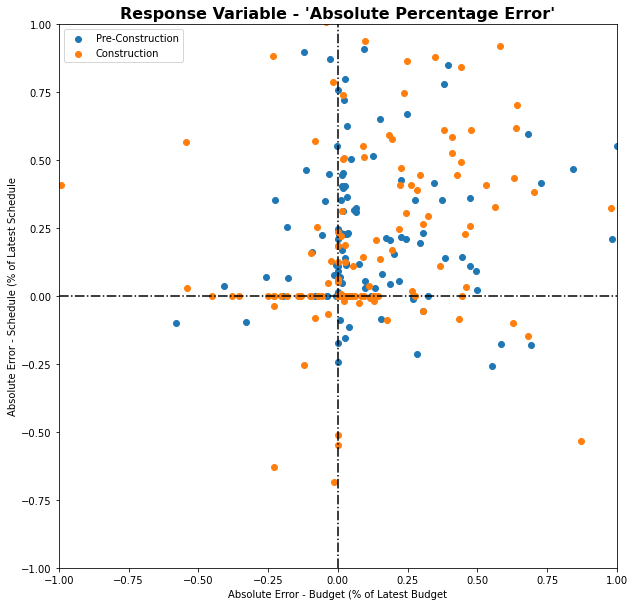

In [0]:
nyc_cp_df_precon_subset = nyc_cp_df_PID_subset[nyc_cp_df_PID_subset['Under_Construction'] == 0].copy()
nyc_cp_df_construction_subset = nyc_cp_df_PID_subset[nyc_cp_df_PID_subset['Under_Construction'] == 1].copy()
plt.figure(figsize=(10,10))
plt.scatter( ( nyc_cp_df_precon_subset['Total_Budget_Changes'] / (nyc_cp_df_precon_subset['Budget_Forecast'] + nyc_cp_df_precon_subset['Total_Budget_Changes']) ) , ( nyc_cp_df_precon_subset['Total_Schedule_Changes'] / ((nyc_cp_df_precon_subset['Forecast_Completion'] - nyc_cp_df_precon_subset['Date_Reported_As_Of']).dt.days) ), label="Pre-Construction")
plt.scatter( ( nyc_cp_df_construction_subset['Total_Budget_Changes'] / (nyc_cp_df_construction_subset['Budget_Forecast'] + nyc_cp_df_construction_subset['Total_Budget_Changes']) ) , ( nyc_cp_df_construction_subset['Total_Schedule_Changes'] / ((nyc_cp_df_construction_subset['Forecast_Completion'] - nyc_cp_df_construction_subset['Date_Reported_As_Of']).dt.days) ), label="Construction")
plt.title("Response Variable - 'Absolute Percentage Error'", fontsize=16, fontweight='bold')
plt.xlabel("Absolute Error - Budget (% of Latest Budget")
plt.ylabel("Absolute Error - Schedule (% of Latest Schedule")
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.axhline(0, linestyle='-.', color="black")
plt.axvline(0, linestyle='-.', color="black")
plt.legend()
plt.show()

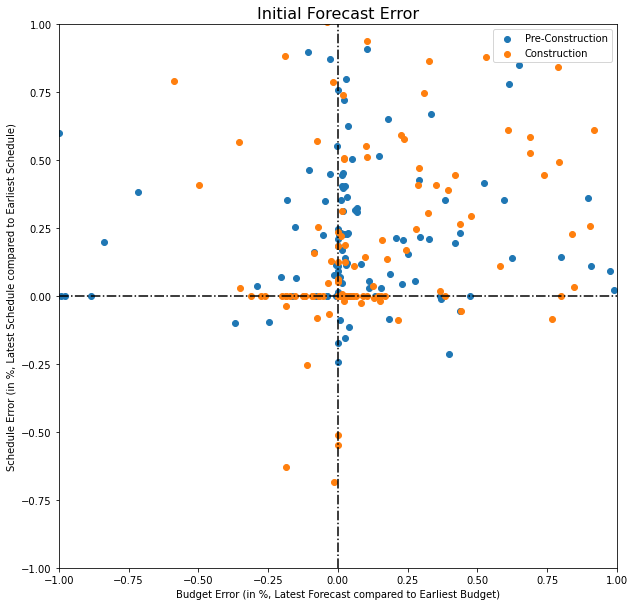

In [0]:
plt.figure(figsize=(10,10))
plt.scatter( ( nyc_cp_df_precon_subset['Total_Budget_Changes'] / nyc_cp_df_precon_subset['Budget_Forecast']  ) , ( nyc_cp_df_precon_subset['Total_Schedule_Changes'] / ((nyc_cp_df_precon_subset['Forecast_Completion'] - nyc_cp_df_precon_subset['Date_Reported_As_Of']).dt.days) ), label="Pre-Construction")
plt.scatter( ( nyc_cp_df_construction_subset['Total_Budget_Changes'] / nyc_cp_df_construction_subset['Budget_Forecast']  ) , ( nyc_cp_df_construction_subset['Total_Schedule_Changes'] / ((nyc_cp_df_construction_subset['Forecast_Completion'] - nyc_cp_df_construction_subset['Date_Reported_As_Of']).dt.days) ), label="Construction")
plt.title("Initial Forecast Error", fontsize=16)
plt.xlabel("Budget Error (in %, Latest Forecast compared to Earliest Budget)")
plt.ylabel("Schedule Error (in %, Latest Schedule compared to Earliest Schedule)")
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.axhline(0, linestyle='-.', color="black")
plt.axvline(0, linestyle='-.', color="black")
plt.legend()
plt.show()

- Above we **plotted the response variable** to understand the distribution of that response. To better understand how forecast date affects the response, above is a comparison of error calculations, using ‘latest’ versus ‘original’ construction phase forecasts. There are slight differences between them, but the metrics perform similarly - indicating **using the latest forecast to calculate the response variable is satisfactory**. 

- Initial review of plots imply that **pre-construction projects are more likely to have variance in schedule**, while p**rojects in construction are more likely to have variance in budget** (the congregation of dots on the 0,0 center cross). Further plots by time may indicate this is due to project age.

**Data Cleaning**

**What did we do?**
- In data section above, we **formatted** and cleaned by dropping missingness from total project budget and schedule (incremental updates are ok), and grouped the dataset into a list of unique project IDs. We **elaborated** the dataset with labels from NYC Open Data, and additional time series deltas (count of days) based on key project milestones. We **classified** the set by adding binary flags for performance / construction status.

**Future actions**
- **Data balancing** - more than half of the dataset contains projects that are both over budget and over schedule. Data augmentation including **upsampling** to balance the number of “successful” projects will be required. There do not appear to be enough projects that satisfactorily meet the absolute percentage error to properly train any data science method (GAM, RNN) in “what is a successful project”. Likewise, data balancing is needed to balance geographic locations (downsample Brooklyn and/or upsample Queens) to be about the same.
- **Data normalization** - since projects have vastly different statuses (some are in construction, others are only in planning), start dates and elapsed time since first recorded projection (time or budget), we have to normalize each for **elapsed time** “time = 0” in order to compare them. Due to the lack of data from “start_of_design” till “first_schedule_update”, models may also require **padding**.


**Data Exploration**

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


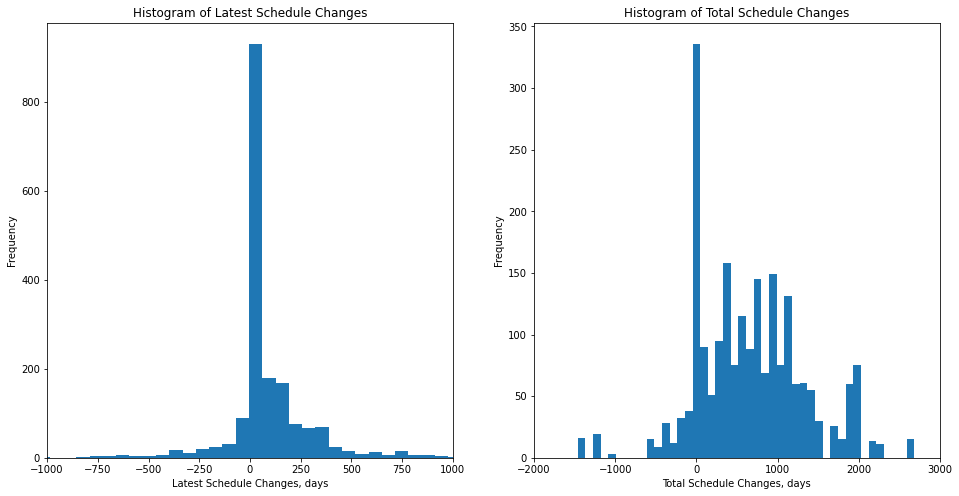

In [0]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].hist(nyc_cp_df['Latest_Schedule_Changes'], bins = 1000)
ax[0].set_xlabel("Latest Schedule Changes, days")
ax[0].set_xscale("linear")
ax[0].set_xlim(-1e3, 1e3)
ax[0].set_ylabel('Frequency')
ax[0].set_title('Histogram of Latest Schedule Changes')

ax[1].hist(nyc_cp_df['Total_Schedule_Changes'], bins = 50)
ax[1].set_xlabel("Total Schedule Changes, days")
ax[1].set_xscale("linear")
ax[1].set_xlim(-2000, 3000)
ax[1].set_ylabel('Frequency')
ax[1].set_title('Histogram of Total Schedule Changes')
plt.show()

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


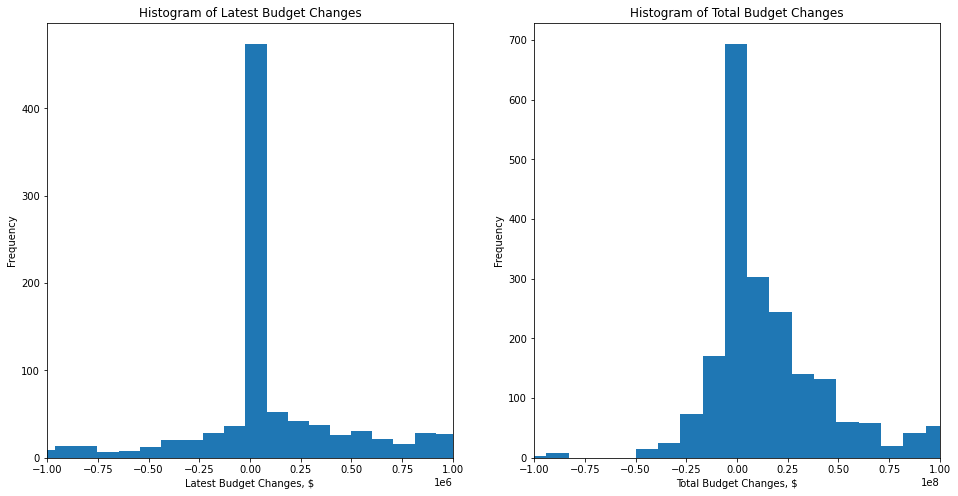

In [0]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].hist(nyc_cp_df['Latest_Budget_Changes'], bins = 10000)
ax[0].set_xlabel("Latest Budget Changes, $")
ax[0].set_xscale("linear")
ax[0].set_xlim(-1e6, 1e6)
ax[0].set_ylabel('Frequency')
ax[0].set_title('Histogram of Latest Budget Changes')

ax[1].hist(nyc_cp_df['Total_Budget_Changes'], bins = 100)
ax[1].set_xlabel("Total Budget Changes, $")
ax[1].set_xscale("linear")
ax[1].set_xlim(-1e8, 1e8)
ax[1].set_ylabel('Frequency')
ax[1].set_title('Histogram of Total Budget Changes')
plt.show()

We plotted histograms of the distributions for the **latest budget changes, total budget changes, latest schedule changes**, and **total schedule changes variables**.  We noticed that all four histograms were centered around zero, which means that most project updates reflected no change from the original budget or schedule.  We also noticed that all four histograms were skewed to the right.  This indicates that there are more projects which are over budget/schedule than projects which are under budget/schedule.  This observation is **in line with our experience and knowledge about capital project successes**.  

In [0]:
df_borough_test_frequency = nyc_cp_df.groupby(by=['PID']).agg(['max'],ascending=False).reset_index()
df_borough_test_frequency

,PID,Column_Description,Date_Reported_As_Of,Project_Name,Category,Borough,Managing_Agency,Client_Agency,Design_Start,Budget_Forecast,Latest_Budget_Changes,Total_Budget_Changes,Forecast_Completion,Latest_Schedule_Changes,Total_Schedule_Changes,Under_Construction,Over_Budget,Over_Schedule,Over_Budget_And_Schedule,On_Budget_And_Schedule
,,max,max,max,max,max,max,max,max,max,max,max,max,max,max,max,max,max,max,max
0,3.0,NaN,2019-09-01,26th Ward Waste Water Treatment Plant Prelimin...,Wastewater Treatment,Brooklyn,DEP,DEP,2013-09-23,185242696.7,8025707.0,-4318643.37,2020-11-30,187.0,270.0,1.0,1.0,1.0,1.0,0.0
1,7.0,NaN,2019-09-01,Bowery Bay Waste Water Treatment Plant Main Se...,Wastewater Treatment,Queens,DEP,DEP,2013-05-01,68798457.0,11312082.0,15305457.00,2020-02-14,396.0,685.0,1.0,1.0,1.0,1.0,0.0
2,18.0,NaN,2019-09-01,Croton Falls Pumping Station Construction,Water Supply,Carmel,DEP,DEP,2003-08-22,103885283.0,39630018.0,1255175.02,2020-03-10,287.0,1014.0,1.0,1.0,1.0,1.0,0.0
3,25.0,NaN,2019-09-01,Gowanus Facilities Upgrade,Wastewater Treatment,Brooklyn,DEP,DEP,2001-12-21,227360175.7,10900102.0,25233101.11,2019-12-31,466.0,1974.0,1.0,1.0,1.0,1.0,0.0
4,34.0,NaN,2019-09-01,Jamaica Waste Water Treatment Plant Upgrades,Wastewater Treatment,Queens,DEP,DEP,1996-05-01,479781786.0,37482177.0,-14632471.11,2019-12-31,435.0,2009.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,1010.0,NaN,2019-09-01,PRIOR NOTICE SIDEWALKS - BROOKLYN,Streets and Roadways,NaN,DDC,DOT,2015-08-06,29427000.0,NaN,NaN,2020-05-13,NaN,NaN,0.0,0.0,0.0,0.0,0.0
374,1011.0,NaN,2019-09-01,"RECONSTRUCTION OF ROSEDALE AREA, PHASE 2",Streets and Roadways,NaN,DDC,DOT,2018-06-07,39360000.0,NaN,NaN,2024-08-14,NaN,NaN,0.0,0.0,0.0,0.0,0.0
375,1012.0,NaN,2019-09-01,"RECONSTRUCTION OF FRONT STREET, MANHATTAN",Streets and Roadways,NaN,DDC,DOT,2015-07-31,27356000.0,NaN,NaN,2022-06-16,NaN,NaN,0.0,0.0,0.0,0.0,0.0


In [0]:
df_borough_frequency = df_borough_test_frequency.groupby(by=[('Borough','max')]).agg(['count']).sort_values([('PID','','count')],ascending=False).reset_index()
df_borough_frequency_result = pd.DataFrame(df_borough_frequency["PID"])
df_borough_frequency_result["Frequency"] = df_borough_frequency["PID"] 
df_borough_frequency_result["Borough"] = df_borough_frequency[('Borough','max')] 

df_borough_frequency_result

/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py:399: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)


,count,Frequency,Borough
0,52,52,Brooklyn
1,34,34,Queens
2,31,31,Manhattan
3,26,26,Bronx
4,14,14,Staten Island
5,11,11,Citywide
6,2,2,New York
7,2,2,Upstate
8,2,2,Valhalla
9,2,2,"Manhattan, Staten Island"


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]), <a list of 19 Text major ticklabel objects>)

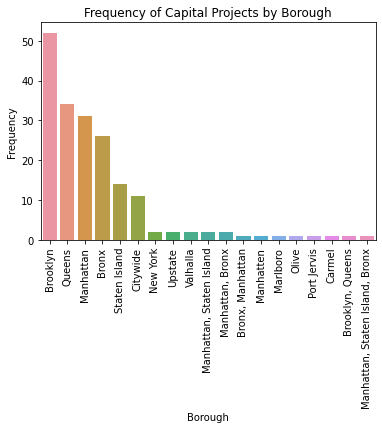

In [0]:
sns.barplot(x="Borough", y="Frequency",  hue=None, color=None, palette=None, data=df_borough_frequency_result).set_title("Frequency of Capital Projects by Borough")
plt.xticks(rotation=90)

In [0]:
df_m_agency_frequency = df_borough_test_frequency.groupby(by=[('Managing_Agency','max')]).agg(['count']).sort_values([('PID','','count')],ascending=False).reset_index()
df_m_agency_frequency_result = pd.DataFrame(df_m_agency_frequency["PID"])
df_m_agency_frequency_result["Frequency"] = df_m_agency_frequency['PID']
df_m_agency_frequency_result["Managing_Agency"] = df_m_agency_frequency[('Managing_Agency','max')] 
df_m_agency_frequency_result

/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py:399: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)


,count,Frequency,Managing_Agency
0,168,168,DDC
1,94,94,DOT
2,38,38,DEP
3,31,31,SCA
4,27,27,EDC
5,5,5,DSNY
6,3,3,DCAS
7,3,3,DPR
8,3,3,HHC
9,2,2,DOC


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text major ticklabel objects>)

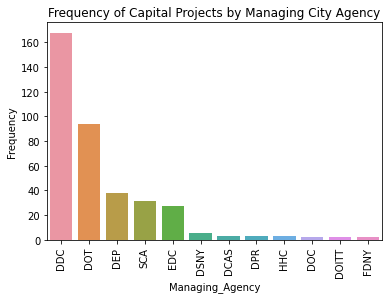

In [0]:
sns.barplot(x="Managing_Agency", y="Frequency",  hue=None, color=None, palette=None, data=df_m_agency_frequency_result).set_title("Frequency of Capital Projects by Managing City Agency")
plt.xticks(rotation=90)

In [0]:
df_category_frequency = df_borough_test_frequency.groupby(by=[('Category','max')]).agg(['count']).sort_values([('PID','','count')],ascending=False).reset_index()
df_category_frequency_result = pd.DataFrame(df_category_frequency["PID"])
df_category_frequency_result["Frequency"] = df_category_frequency["PID"] 
df_category_frequency_result["Category"] = df_category_frequency[('Category','max')]

df_category_frequency_result

/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py:399: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)


,count,Frequency,Category
0,89,89,Streets and Roadways
1,43,43,Sewers
2,37,37,Industrial Development
3,31,31,Schools
4,30,30,Water Supply
5,29,29,Wastewater Treatment
6,23,23,Bridges
7,18,18,"Bridges, Streets and Roadways"
8,15,15,Public Safety and Criminal Justice
9,12,12,Parks


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]), <a list of 22 Text major ticklabel objects>)

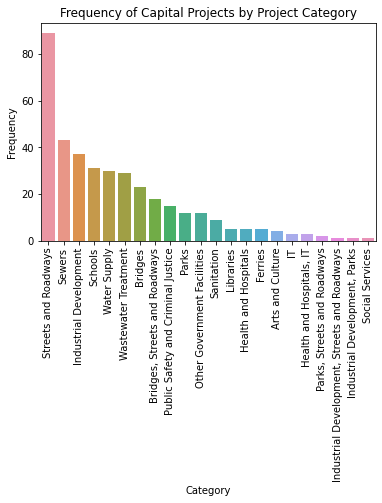

In [0]:
sns.barplot(x="Category", y="Frequency",  hue=None, color=None, palette=None, data=df_category_frequency_result).set_title("Frequency of Capital Projects by Project Category")
plt.xticks(rotation=90)

We observe that the **largest number of capital projects** in the dataset are:
- **managed by the DDC** (Department of Design and Construction), followed by the DOT (Department of Transportation), the DEP (Department of Environmental Protection), the EDC (Economic Development Corporation), and SCA (School Construction Authority).  One of the areas our team would like to investigate are whether city agencies which are geared towards construction and development (ex. DDC, SCA) have a higher rate of project success than other agencies where design and construction are only a small part of the agency’s mission (ex. FDNY, DSNY, etc.)
 
- **in the Brooklyn borough of New York City**, followed by Queens and Manhattan.  There are some capital projects which involve two or more boroughs, as well as other capital projects which lie outside of New York City.  
 
- **involve street and roadway infrastructure**, followed by water supply, wastewater treatment, sewers, and bridges.   


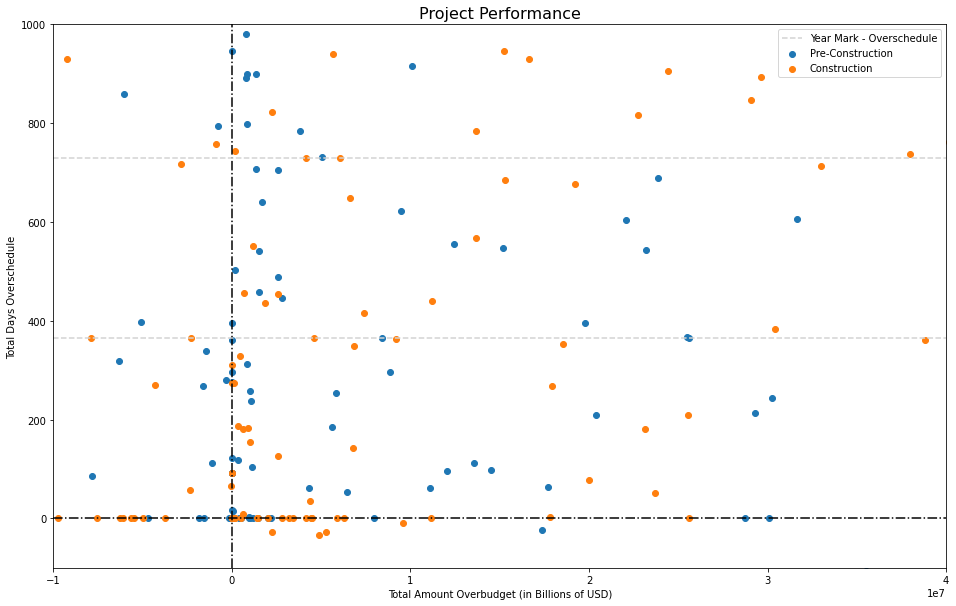

In [0]:
plt.figure(figsize=(16,10))
plt.scatter(nyc_cp_df_precon_subset['Total_Budget_Changes'], nyc_cp_df_precon_subset['Total_Schedule_Changes'], label="Pre-Construction")
plt.scatter(nyc_cp_df_construction_subset['Total_Budget_Changes'], nyc_cp_df_construction_subset['Total_Schedule_Changes'], label="Construction")
plt.title("Project Performance", fontsize=16)
plt.xlabel("Total Amount Overbudget (in Billions of USD)")
plt.ylabel("Total Days Overschedule")
plt.xlim(-10000000,40000000)
plt.ylim(-100,1000)
plt.axhline(0, linestyle='-.', color="black")
plt.axvline(0, linestyle='-.', color="black")
plt.axhline(365, linestyle='--', color="lightgray", label="Year Mark - Overschedule")
plt.axhline(365*2, linestyle='--', color="lightgray")
plt.legend(loc='upper right')
plt.show()

We observe that the **majority of projects with serious temporal and cost issues are all in the construction phase**. We again note that due to vastly different scopes and types of project size, over budget and lateness are vastly different scales. This further supports the necessity of using a relative percentage error metric.

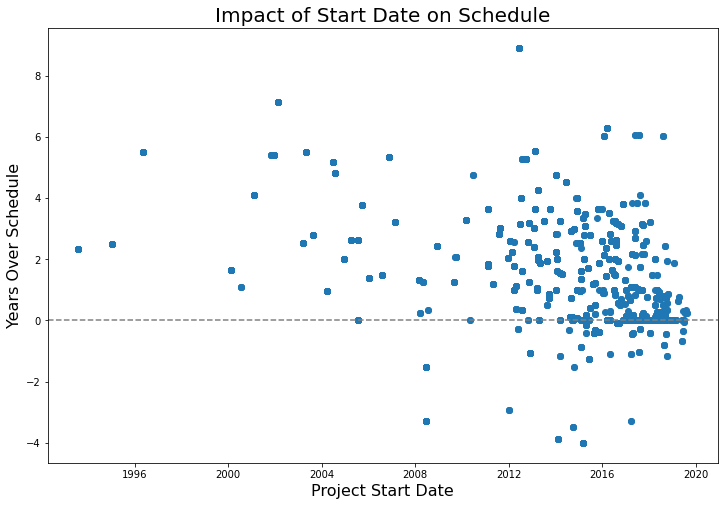

In [0]:
plt.figure(figsize=(12,8))
plt.scatter(nyc_cp_df['Design_Start'], nyc_cp_df['Total_Schedule_Changes']/365)
plt.axhline(0, linestyle='--', color="grey", label="Start of Design")
plt.xlabel("Project Start Date",fontsize=16)
plt.ylabel("Years Over Schedule",fontsize=16)
plt.title("Impact of Start Date on Schedule",fontsize=20)
plt.show()

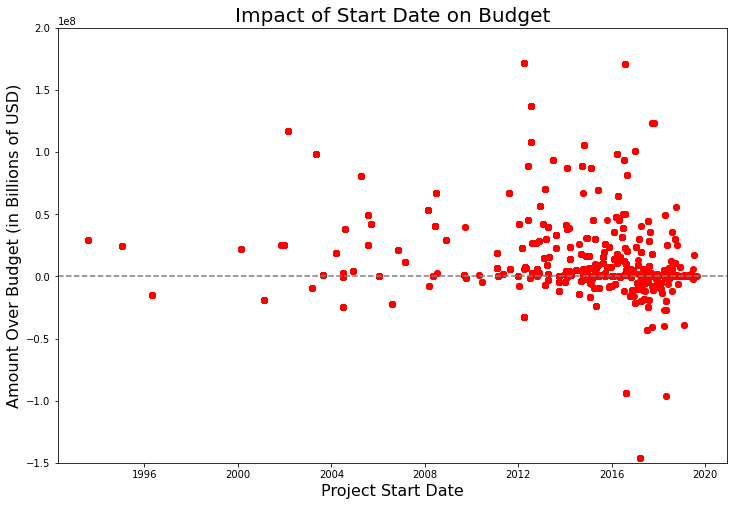

In [0]:
nyc_cp_df_slice = nyc_cp_df.dropna()
plt.figure(figsize=(12,8))
plt.scatter(nyc_cp_df['Design_Start'], nyc_cp_df['Total_Budget_Changes'], color='red')
plt.axhline(0, linestyle='--', color="grey", label="Start of Design")
plt.ylim(-150000000,200000000)
plt.xlabel("Project Start Date",fontsize=16)
plt.ylabel("Amount Over Budget (in Billions of USD)",fontsize=16)
plt.title("Impact of Start Date on Budget",fontsize=20)
plt.show()

We observe that time series will factor heavily into this project, as project start date, and elapsed time have a clear factor on budget and schedule. Perhaps obviously, plots above show the **longer a project runs the more difficult forecasting cost and budget becomes**.

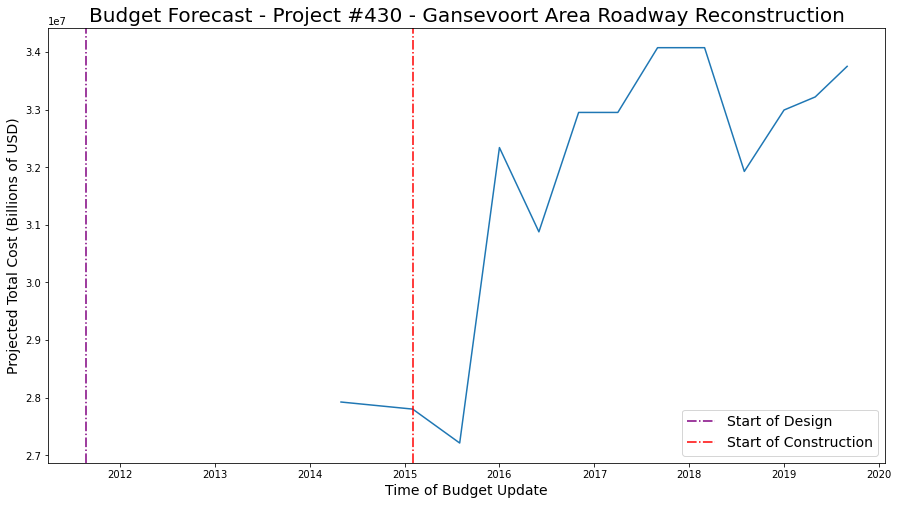

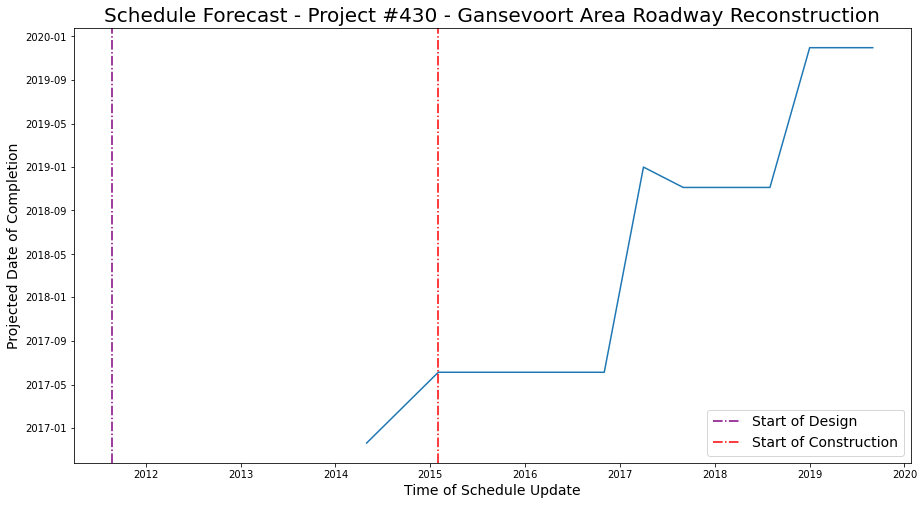

In [0]:
def print_project_status(pid_number, design_plot=False, construction_plot=True):
  nyc_cp_df_slice = nyc_cp_df[nyc_cp_df['PID'] == pid_number]

  plt.figure(figsize=(15,8))
  plt.plot(nyc_cp_df_slice['Date_Reported_As_Of'], nyc_cp_df_slice['Budget_Forecast'])
  if design_plot:
    plt.axvline(nyc_cp_df_slice.iloc[0,10], linestyle='-.', color="purple", label="Start of Design") #Design Start
  if construction_plot:
    if nyc_cp_df_slice.iloc[0,17] !=0:
      plt.axvline(nyc_cp_df_slice.iloc[0,17], linestyle='-.', color="red", label="Start of Construction") #Construction_Start
      plt.legend(fontsize=14)
  plt.title("Budget Forecast - Project #%s - %s" % (int(nyc_cp_df_slice.iloc[0,2]),nyc_cp_df_slice.iloc[0,3]), fontsize=20)
  plt.xlabel("Time of Budget Update", fontsize=14)
  plt.ylabel("Projected Total Cost (Billions of USD)", fontsize=14)
  plt.show()

  plt.figure(figsize=(15,8))
  plt.plot(nyc_cp_df_slice['Date_Reported_As_Of'], nyc_cp_df_slice['Forecast_Completion'])
  if design_plot:
    plt.axvline(nyc_cp_df_slice.iloc[0,10], linestyle='-.', color="purple", label="Start of Design") #Design Start
  if construction_plot:
    if nyc_cp_df_slice.iloc[0,17] !=0:
      plt.axvline(nyc_cp_df_slice.iloc[0,17], linestyle='-.', color="red", label="Start of Construction") #Construction_Start
      plt.legend(fontsize=14)
  plt.title("Schedule Forecast - Project #%s - %s" % (int(nyc_cp_df_slice.iloc[0,2]),nyc_cp_df_slice.iloc[0,3]), fontsize=20)
  plt.xlabel("Time of Schedule Update", fontsize=14)
  plt.ylabel("Projected Date of Completion", fontsize=14)
  plt.show()

#for i in range (0,25+1,1):
  #print_project_status(np.random.choice(unique_projects), False, True)
print_project_status(430, True, True)

To better understand the **time series data**, we spot analysed and compared 25 projects; Above is an example pair-plot for a roadway reconstruction project.

- A common theme is shown, that after the start of construction, cost and schedule rapidly increase. This demonstrates an issue we expect may be an issue in forecasting project success - A **lack of updated forecasts during the design phase of the project**, leading to an unrealistic expectation of time and cost.

- It is also of note, that many significant schedule updates occur about the time the last update indicated the project would be complete - this **poor intermittent updating also makes it difficult to anticipate changes forecast time and cost**.

- This time series data above implies a **slope/rate of cost and schedule change** at various phases that is of interest. The elapsed time at which this slope changes could be useful. Also the "knot" at which these change is also of note. It is highly likely that the knot is at start of construction. 

**Principal Components Analysis - Clustering Feasibility**

In [0]:
nyc_cp_df_pca_subset = nyc_cp_df.select_dtypes(include = ['float64', 'int64'])
nyc_cp_df_pca_subset = nyc_cp_df_pca_subset.dropna()

std_columns = ['Budget_Forecast', 'Latest_Budget_Changes',	'Total_Budget_Changes',	'Latest_Schedule_Changes',	'Total_Schedule_Changes']

for column in std_columns:
  scaler = StandardScaler()
  nyc_cp_df_pca_subset.loc[:,column] = scaler.fit_transform(np.array(nyc_cp_df_pca_subset.loc[:,column]).reshape(-1, 1))

explained variance ratio (first two components): [0.31675486 0.20936597]


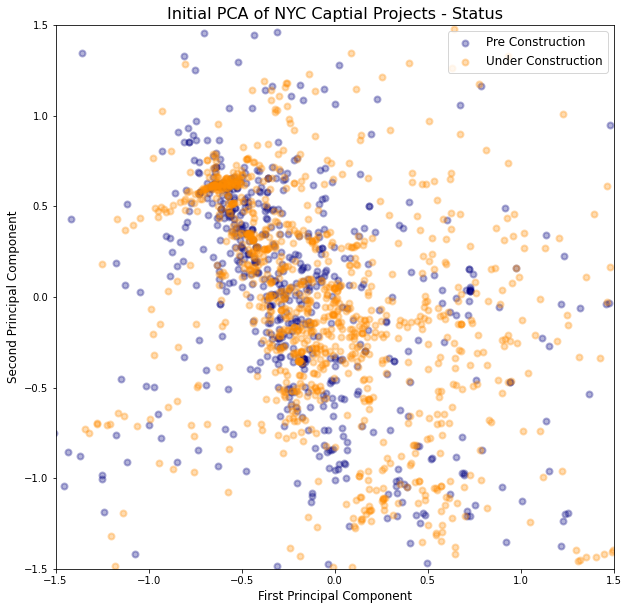

In [0]:
X = nyc_cp_df_pca_subset.iloc[:,1:5+1]
y = nyc_cp_df_pca_subset.iloc[:,6]
target_names = ['Pre Construction','Under Construction']

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure(figsize=(10,10))
colors = ['navy', 'darkorange']
lw = 2

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.3, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1, fontsize=12)
plt.title('Initial PCA of NYC Captial Projects - Status', fontsize=16)
plt.xlabel("First Principal Component", fontsize=12)
plt.ylabel("Second Principal Component", fontsize=12) 
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.show()

In [0]:
#nyc_cp_df_pca_subset.iloc[:,7:8]

explained variance ratio (first two components): [0.31675486 0.20936597]


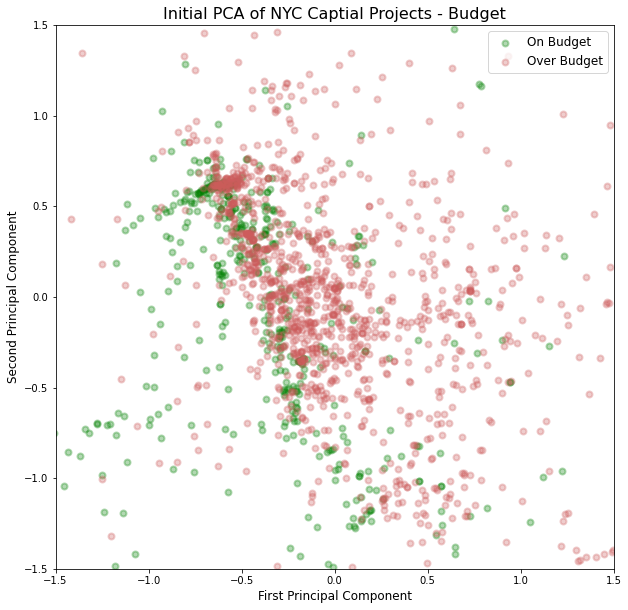

In [0]:
X = nyc_cp_df_pca_subset.iloc[:,1:5+1]
y = nyc_cp_df_pca_subset.iloc[:,7]
target_names = ['On Budget','Over Budget']

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure(figsize=(10,10))
colors = ['green', 'indianred']
lw = 2

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.3, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1, fontsize=12)
plt.title('Initial PCA of NYC Captial Projects - Budget', fontsize=16)
plt.xlabel("First Principal Component", fontsize=12)
plt.ylabel("Second Principal Component", fontsize=12) 
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.show()

explained variance ratio (first two components): [0.31675486 0.20936597]


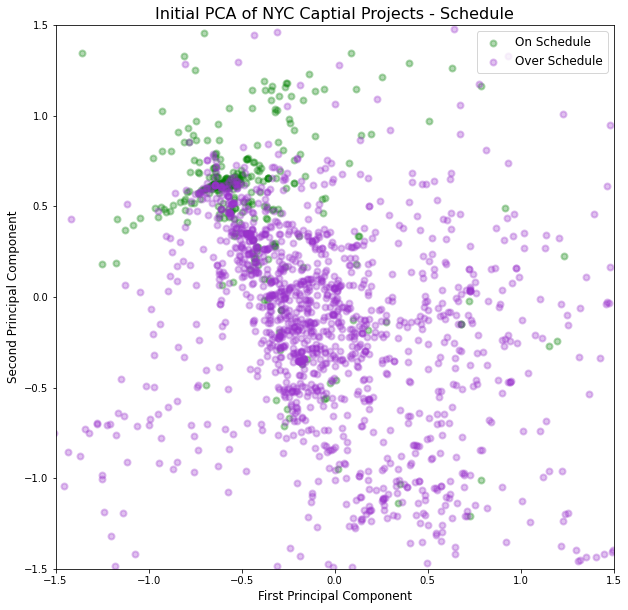

In [0]:
X = nyc_cp_df_pca_subset.iloc[:,1:5+1]
y = nyc_cp_df_pca_subset.iloc[:,8]
target_names = ['On Schedule', 'Over Schedule']

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure(figsize=(10,10))
colors = ['green', 'darkorchid']
lw = 2

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.3, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1, fontsize=12)
plt.title('Initial PCA of NYC Captial Projects - Schedule', fontsize=16)
plt.xlabel("First Principal Component", fontsize=12)
plt.ylabel("Second Principal Component", fontsize=12) 
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.show()

To initially examine if there are sufficient descriptor variables to allow the data to be successfully separated by “success” metrics into clusters, **we performed dimensionality reduction on the full dataset**. 

- We first investigated ‘project phase’, ‘budget status’ and ‘schedule status’ as cluster labels.

- Principal components analysis was only moderately successful, capturing just over half of the variance in the dataset (explained variance in the first two principal components was **31.67%** and **20.94%**).

- This shows the **dataset needs further data augmentation to properly cluster** (by success);
Even by category, there's insufficient variance to separate, and draw clear class boundaries.


**Summary**

Exploratory Data Analysis shows that there is a wealth of time-series data available, but **further augmentation, tagging and processing is required** to extract its full value and produce a rich predictive model. Enhancement of time-series and text data and is a priority to properly cluster it.



**Next Steps**

As an **initial goal:**
- we want to build a model to forecast a current project’s absolute percentage error - it is anticipated this will be a GAM based model (validated using ARIMA). We also look to categorize the project data by these metrics, by auto-encoding the project into a lower dimensional latent space (using auto-encoder neural networks), and labeling that latent space. 

As **stretch goals:**
- we look to predict a project success in as much detail as possible, if it is possible to forecast the running future of a project, and evaluate different trajectories each project may take (given certain choices). To that end we will evaluate and attempt to apply Recurrent neural networks (RNN), variational-auto-encoding (VAE) and reinforcement learning. 

- Using VAE would allow us to sample a hypothetical new project of a specific type and schedule/budget status from existing projects- it could provide a detailed forecast, that is especially useful for projects with size and scope that does not match any existing project. A challenge to this is that there may likely be insufficient variance in the data to sample from a continuous latent space generated by a VAE in a way that the resulting “theoretical project” is meaningful (the results  may be highly biased).

- Reinforcement learning would be tricky to apply, but provide enormous predictive power at any project state by recommending optimal value decision making. If we can successfully infer states and actions, we can re-evaluate existing projects by off-policy sampling - determining the value of alternate choices to find better ones. Additionally, if we can and derive transition probabilities by sampling from existing projects, then we can evaluate brand new projects - simulating trajectories and selecting optimal policy for new projects at each step.

- Recurrent neural networks are likely to have the highest chance of success, specifically Gated Recurrent Units (GRU) at predicting time series data. We will initially attempt many-to-one models, that ingests past project series and generates the next budget and schedule update. Initial research indicates a time series bias needs to be applied and calibrated, as the forecasted values may become out of step from the actual ones (being consistently late). We may find neural networks prove to be too powerful to utilize on such a low dimensionality dataset.


**References**

Baucells, M., Grushka-Cockayne, Y., Hwang, W. (2019).  The Effects of Mental Accounting on Project Performance.

Grushka-Cockayne, Yael. (2015). New York City Department of Parks and Recreation. Darden School Foundation UVA-QA-0815TN. Charlottesville, VA: Darden Business Publishing.

Lukas, J. A. (2012). How to make earned value work on your project. Paper presented at PMI® Global Congress 2012—North America, Vancouver, British Columbia, Canada. Newtown Square, PA: Project Management Institute.

Mayor's Office of Operations. (2019, November 15). Capital Projects: NYC Open Data. Retrieved April 13, 2020, from https://data.cityofnewyork.us/City-Government/Capital-Projects/n7gv-k5yt


**END OF EDA REPORT**